Training ResNet on CIFAR 10 dataset, and comparing metrics between fused layer model and ordinary ResNet

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='C:\Tejeswar\Fusion\CIFAR10_dataset', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, pin_memory=True,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='C:\Tejeswar\Fusion\CIFAR10_dataset', train=False,
                                       download=False, transform=transform)

val_dataset_size = len(testset) // 2
test_dataset_size = len(testset) - val_dataset_size

val_dataset, final_test_dataset = random_split(testset, [val_dataset_size, test_dataset_size])

# DataLoaders
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(final_test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [17]:
# for input_data, labels in test_loader:
#     print(input_data.size())
#     np_array = input_data.numpy()
#     print(np_array.shape)

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

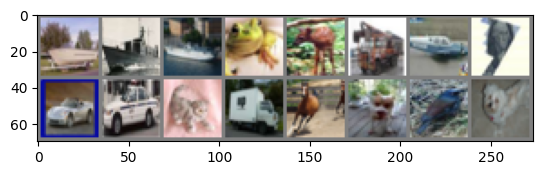

ship  ship  ship  frog  deer  truck plane plane car   car   cat   truck horse dog   bird  dog  


In [12]:
# Optional - get some random training images (Visualizing the images)
dataiter = iter(trainloader)
images, labels = next(dataiter)
            
# show images
imshow(torchvision.utils.make_grid(images))
# print labels 
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
print("CUDA Available:", torch.cuda.is_available())
print("Device Count:", torch.cuda.device_count())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")
print("Torch CUDA Version:", torch.version.cuda)
print("Current Device:", torch.cuda.current_device() if torch.cuda.is_available() else "N/A")


CUDA Available: True
Device Count: 1
Device Name: NVIDIA GeForce RTX 3050 Laptop GPU
Torch CUDA Version: 12.6
Current Device: 0


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
print(device)

cuda


In [5]:
import torchvision
import torch.nn as nn

def get_resnet50_for_CIFAR10():
    # CIFAR 10 has 10 classes, so the last layer should be a fully conneted with size 10
    net = torchvision.models.resnet50()

    # Get the number of input features to the last fully connected layer
    in_features = net.fc.in_features

    # Replace the last fully connected layer with a new one for 10 classes
    net.fc = nn.Linear(in_features, 10)
    return net

In [14]:
net = get_resnet50_for_CIFAR10()

net = net.to(device)

In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
ep = 5 #You can increase for better accuracy
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


for epoch in range(ep):  # loop over the dataset multiple times
    net.train()

    batch_loss = 0.0
    train_loss = 0.0
    correct, total = 0, 0

    # Training Phase
    for i, data in enumerate(trainloader, 0):
        # print("bATCH: ", i)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()
        train_loss += loss.item()
        _, predicted = outputs.max(1)    
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        # print statistics
        if ((i + 1) % 200 == 0):    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {batch_loss / 200:.3f}')
            batch_loss = 0.0
        
    train_loss = train_loss / len(trainloader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    net.eval() 
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)

            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch Completed:  {epoch + 1},  Train Loss: {train_loss} , Val Loss: {val_loss}")

print('Finished Training')

[1,   200] loss: 2.649
[1,   400] loss: 2.566
[1,   600] loss: 2.362
[1,   800] loss: 2.269
[1,  1000] loss: 2.265
[1,  1200] loss: 2.161
[1,  1400] loss: 2.064
[1,  1600] loss: 2.026
[1,  1800] loss: 1.982
[1,  2000] loss: 1.944
[1,  2200] loss: 1.991
[1,  2400] loss: 1.932
[1,  2600] loss: 1.860
[1,  2800] loss: 1.899
[1,  3000] loss: 1.887
Epoch Completed:  1,  Train Loss: 2.1093933097267152 , Val Loss: 1.864122882247352
[2,   200] loss: 1.843
[2,   400] loss: 1.835
[2,   600] loss: 1.687
[2,   800] loss: 1.764
[2,  1000] loss: 1.733
[2,  1200] loss: 1.774
[2,  1400] loss: 1.746
[2,  1600] loss: 1.687
[2,  1800] loss: 1.760
[2,  2000] loss: 1.723
[2,  2200] loss: 1.690
[2,  2400] loss: 1.710
[2,  2600] loss: 1.620
[2,  2800] loss: 1.680
[2,  3000] loss: 1.640
Epoch Completed:  2,  Train Loss: 1.7241428836631776 , Val Loss: 2.7078579369063576
[3,   200] loss: 1.588
[3,   400] loss: 1.594
[3,   600] loss: 1.527
[3,   800] loss: 1.582
[3,  1000] loss: 1.614
[3,  1200] loss: 1.550
[3,  

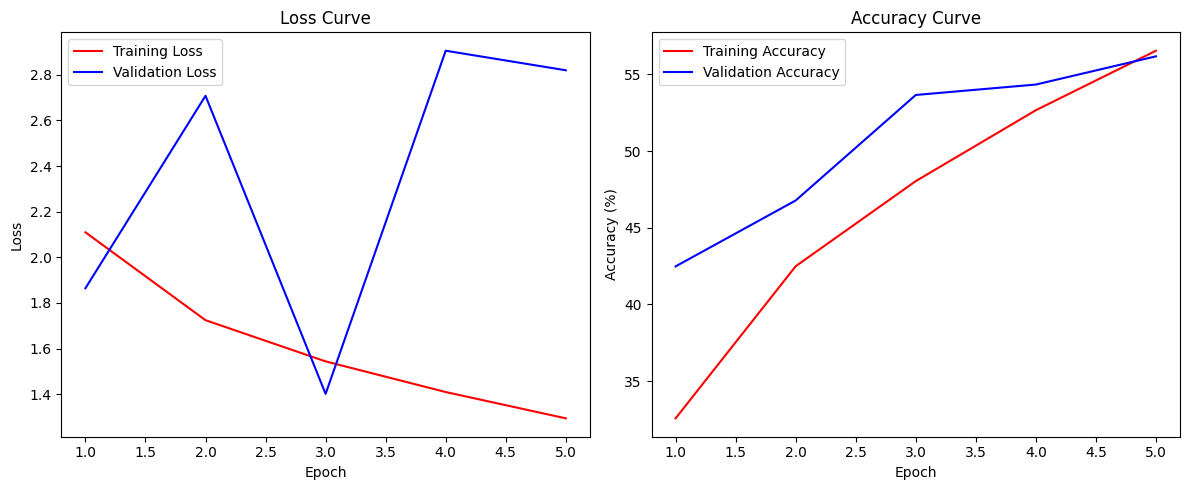

In [15]:
epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r-', label='Training Loss')
plt.plot(epochs, val_losses, 'b-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'b-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()


In [17]:
PATH = './resnet50_new.pth'
torch.save(net.state_dict(), PATH)

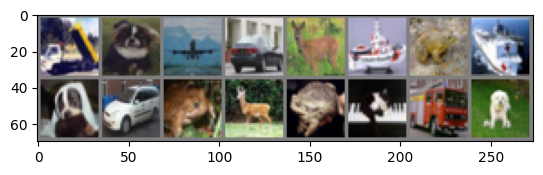

GroundTruth:  truck dog   plane car  


In [18]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [6]:
PATH = './resnet50_new.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# net = torchvision.models.resnet50()

# in_features = net.fc.in_features

# # Replace the last fully connected layer with a new one for 10 classes
# net.fc = nn.Linear(in_features, 10)

net = get_resnet50_for_CIFAR10()

net.load_state_dict(torch.load(PATH, weights_only=True))

net = net.to(device)


In [8]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 41.6 %
Accuracy for class: car   is 63.5 %
Accuracy for class: bird  is 29.1 %
Accuracy for class: cat   is 27.0 %
Accuracy for class: deer  is 42.6 %
Accuracy for class: dog   is 66.9 %
Accuracy for class: frog  is 65.7 %
Accuracy for class: horse is 61.5 %
Accuracy for class: ship  is 81.3 %
Accuracy for class: truck is 56.8 %


In [9]:
# Warm up the GPU for accurate timeing
with torch.no_grad():
    for i in range(5):
        for images, label in test_loader:
            images = images.to(device) 
            _ = net(images)
            # Wait for all operations ti be completed
            break

In [8]:
# Calculate the inference time and acuracy of the model using the test dataset
import time

# net.to(device)  # Ensure the model is on GPU

net.eval()  # Set model to evaluation mode

correct = 0
total = 0

total_time = 0.0
total_images = 0
batches_count = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # Wait for all operatiosn to finish
        torch.cuda.synchronize()

        start_time = time.time()

        # calculate outputs by running images through the network
        outputs = net(images)

        #Ensure the forward pass is completed
        torch.cuda.synchronize()

        end_time = time.time()

        # Add the total time
        total_time += (end_time - start_time)  # batch inference time

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_images += images.size(0)

        batches_count += 1

end_time = time.time()   
# Calculate timimng per batch 
avg_inference_time = total_time / batches_count
print(f'Accuracy of the network on the {len(test_loader)} test batches: {100 * correct // total} %')
print(f"Inference Spped (per Batch on average) : {avg_inference_time} seconds ( {(avg_inference_time * 1000):.2f} milliseconds)" )

Accuracy of the network on the 313 test batches: 56 %
Inference Spped (per Batch on average) : 0.011756327205572646 seconds ( 11.76 milliseconds)


In [10]:
# Host to Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

total_cpu_to_gpu_time = 0.0
batch_count = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data

        start = time.time()
        images = images.to(device)
        labels = labels.to(device)
        torch.cuda.synchronize()  # Ensure copy is done
        end = time.time()
        total_cpu_to_gpu_time += (end - start)
        batch_count += 1

avg_host_to_device_time = total_cpu_to_gpu_time / batch_count

print(f"Avg Host to Device (CPU to GPU) transfer time per batch: {avg_host_to_device_time:.6f} seconds ({(avg_host_to_device_time * 1000):.2f} milliseconds)")

Avg Host to Device (CPU to GPU) transfer time per batch: 0.001094 seconds (1.09 milliseconds)


In [11]:
# Device to Host

total_gpu_to_cpu_time = 0.0
batch_count = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)

        outputs = net(images)
        torch.cuda.synchronize()

        start = time.time()
        predictions = outputs.cpu()  # Transfer to CPU
        torch.cuda.synchronize()
        end = time.time()

        batch_count += 1
        total_gpu_to_cpu_time += (end - start)


avg_device_to_host_time = total_gpu_to_cpu_time / batch_count

print(f"Avg Device to Host (GPU to CPU) transfer time per batch: {avg_device_to_host_time:.6f} seconds ({(avg_device_to_host_time * 1000):.2f} milliseconds)")


Avg Device to Host (GPU to CPU) transfer time per batch: 0.000131 seconds (0.13 milliseconds)


## Layer Fusion and Kernel Fusion

In [14]:
import torchvision.models as models
from torch.quantization import fuse_modules


# model = models.resnet50(pretrained=True)
# model.eval()

PATH = r".\resnet50_new.pth"

model_resnet = get_resnet50_for_CIFAR10()

model_resnet.load_state_dict(torch.load(PATH, weights_only=True))

model_resnet.eval()

# Step 2: Apply Layer Fusion
def fuse_resnet(model):
    """
    Fuses Conv-BN layers in a ResNet model using torch.quantization.fuse_modules.
    This is generally more robust for standard architectures like ResNet.
    Modifies the model in-place.
    """
    model.eval() # Ensure model is in eval mode for fusion

    # List of layers to fuse for a typical ResNet block structure
    # For a BasicBlock (used in ResNet18/34), it's conv1, bn1 and conv2, bn2
    # For a Bottleneck block (used in ResNet50/101/152), it's conv1, bn1; conv2, bn2; conv3, bn3;
    # and optionally downsample.0, downsample.1
    
    # We need to iterate through the model's modules and apply fusion recursively.
    # The `torch.quantization.fuse_modules` function works on a list of module names within a parent.

    # Function to apply fusion within a block
    def apply_fusion_to_block(block):
        if isinstance(block, models.resnet.BasicBlock):
            torch.quantization.fuse_modules(block, [['conv1', 'bn1'], ['conv2', 'bn2']], inplace=True)
        elif isinstance(block, models.resnet.Bottleneck):
            torch.quantization.fuse_modules(block, [['conv1', 'bn1'], ['conv2', 'bn2'], ['conv3', 'bn3']], inplace=True)
        elif isinstance(block, nn.Sequential):
            # For sequential blocks, we need to iterate and try to fuse within them
            # This handles the stem and other sequential parts
            # Example: ResNet's initial conv and bn
            if hasattr(block, '0') and isinstance(block[0], nn.Conv2d) and \
               hasattr(block, '1') and isinstance(block[1], nn.BatchNorm2d):
               torch.quantization.fuse_modules(block, [['0', '1']], inplace=True)
        # Handle downsample path if it exists and is a sequential with conv-bn
        if hasattr(block, 'downsample') and block.downsample is not None:
            if isinstance(block.downsample, nn.Sequential) and \
               len(block.downsample) == 2 and \
               isinstance(block.downsample[0], nn.Conv2d) and \
               isinstance(block.downsample[1], nn.BatchNorm2d):
                torch.quantization.fuse_modules(block.downsample, [['0', '1']], inplace=True)


    # Traverse the model and apply fusion
    for name, module in model.named_children():
        if isinstance(module, (nn.Sequential, nn.ModuleList)):
            for sub_name, sub_module in module.named_children():
                apply_fusion_to_block(sub_module)
        elif isinstance(module, (models.resnet.BasicBlock, models.resnet.Bottleneck)):
            apply_fusion_to_block(module)
        elif name == 'conv1' and isinstance(module, nn.Conv2d): # Handle the stem conv1
            # The stem conv1 and bn1 are usually direct children of the model
            if hasattr(model, 'bn1') and isinstance(model.bn1, nn.BatchNorm2d):
                print(f"Fusing model.conv1 and model.bn1...")
                fused_stem = torch.nn.utils.fuse_conv_bn_eval(model.conv1, model.bn1)
                model.conv1 = fused_stem
                model.bn1 = nn.Identity() # Replace BN with Identity
            
    print("ResNet Conv-BN fusion complete using torch.quantization.fuse_modules.")


fuse_resnet(model_resnet)

Fusing model.conv1 and model.bn1...
ResNet Conv-BN fusion complete using torch.quantization.fuse_modules.


In [15]:
PATH = './resnet50_fused_new.pth'
torch.save(model_resnet.state_dict(), PATH)

Convert the model to the ONNX format and store

In [23]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models

output_onnx="resnet50_fused_new.onnx"

PATH = r".\resnet50_fused_new.pth"

model  = torchvision.models.resnet50() 
in_features = model.fc.in_features
# Replace the last fully connected layer with a new one for 10 classes
model.fc = nn.Linear(in_features, 10)
fuse_resnet(model)

model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()
 
batch_size = 16
# Generate input tensor with random values
input_tensor = torch.rand(batch_size, 3, 32, 32)
 
# Export torch model to ONNX
print("Exporting ONNX model {}".format(output_onnx))
torch.onnx.export(model, input_tensor, output_onnx,
    opset_version=12,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch", 2: "height", 3: "width"},
                  "output": {0: "batch", 2: "height", 3: "width"}},
    verbose=False)
 

NameError: name 'fuse_resnet' is not defined

Create TensorRT engine from the ONNX file

In [34]:
# This code works for Resnet and CIFAR 10

import tensorrt as trt
import pycuda.driver as cuda
batch_size = 16

trtEngineName = "resnet50_fused_new.trt"

onnxPath = "resnet50_fused_new.onnx"

TRT_LOGGER = trt.Logger()
builder = trt.Builder(TRT_LOGGER)
network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
parser = trt.OnnxParser(network, TRT_LOGGER)

with open(onnxPath, "rb") as model_file:
    if not parser.parse(model_file.read()):
        print("ERROR: Failed to parse ONNX model")
        for i in range(parser.num_errors):
            print(parser.get_error(i))
        raise SystemExit(1)
print("✔️ ONNX parsed successfully")

config = builder.create_builder_config()
config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 1 << 29)

# Enable FP16 if supported
if builder.platform_has_fast_fp16:
    print(1)
    config.set_flag(trt.BuilderFlag.FP16)

# Create optimization profile
profile = builder.create_optimization_profile()
input_name = network.get_input(0).name

# The engine has dynamic input shape allocation - we specify the minimum ans maximum shape.
profile.set_shape(input_name, min=(1, 3,  32,  32),   # smallest batch you’ll ever send
                   opt=(batch_size, 3, 224, 224),   # “typical” size for fastest kernels
                   max=(batch_size, 3, 512, 512) )  # largest you want to handle)

config.add_optimization_profile(profile)

print("Building engine…")
engine = builder.build_engine_with_config(network, config)
if engine is None:
    raise RuntimeError("❌ Engine build failed")

with open(trtEngineName, "wb") as f:
    f.write(engine.serialize())
print("✔️ Engine serialized to " + trtEngineName)

✔️ ONNX parsed successfully
1
Building engine…
✔️ Engine serialized to resnet50_fused_new.trt


### Inferencing TensorRT engine - TensorRT automatically does grid level paallelism and batch lernel level parallelism

In [12]:
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
import time
import tensorrt as trt

def timed_infer_batches(engine, test_loader):
    # Assume input_image is np.array (1,3,32,32), dtype=float32
    TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
    runtime = trt.Runtime(TRT_LOGGER)
    
    with open(engine, "rb") as f:
        engine = runtime.deserialize_cuda_engine(f.read())
    context = engine.create_execution_context()

    outputs = []
    total_inference_time = 0
    total_host_to_device_time = 0
    total_device_to_host_time = 0
    total_time = 0

    batches_seen = 0

    for (input_data, label) in test_loader:
        input_image = input_data.numpy()
        # preprocess the image
        # input_image = pre_process_single_image(input_image)

        input_name = engine.get_tensor_name(0)
        output_name = engine.get_tensor_name(1)
        context.set_input_shape(input_name, input_image.shape)

        # Allocate memory
        input_image = np.ascontiguousarray(input_image.astype(np.float32))
        output_shape = context.get_tensor_shape(output_name)
        output_size = int(np.prod(output_shape))
        # print(output_shape, output_size)
        output_dtype = trt.nptype(engine.get_tensor_dtype(output_name))

        device_input = cuda.mem_alloc(input_image.nbytes)
        device_output = cuda.mem_alloc(output_size * np.dtype(output_dtype).itemsize)

        context.set_tensor_address(input_name, int(device_input))
        context.set_tensor_address(output_name, int(device_output))

        # Prepare output buffer
        host_output = np.empty(output_shape, dtype=output_dtype)

        stream = cuda.Stream()

        # CUDA Events for timing
        start_h2d = cuda.Event()
        end_h2d = cuda.Event()

        start_exec = cuda.Event()
        end_exec = cuda.Event()

        start_d2h = cuda.Event()
        end_d2h = cuda.Event()

        # Host to Device
        start_h2d.record(stream)
        cuda.memcpy_htod_async(device_input, input_image, stream)
        end_h2d.record(stream)

        # Inference
        start_exec.record(stream)
        context.execute_async_v3(stream.handle)
        end_exec.record(stream)

        # Device to Host
        start_d2h.record(stream)
        cuda.memcpy_dtoh_async(host_output, device_output, stream)
        end_d2h.record(stream)

        # Synchronize
        stream.synchronize()

        # Measure times (ms)
        h2d_time = start_h2d.time_till(end_h2d)
        exec_time = start_exec.time_till(end_exec)
        d2h_time = start_d2h.time_till(end_d2h)

        total_inference_time += exec_time
        total_host_to_device_time += h2d_time
        total_device_to_host_time += d2h_time
        
        batch_time = h2d_time + exec_time + d2h_time
        total_time += batch_time
        # print(batch_time)
        outputs.append(host_output[0])
        batches_seen += 1

    
    # Calulate the avegare time
    avg_inference_time_trt = total_inference_time / batches_seen
    avg_host_to_device_time = total_host_to_device_time / batches_seen
    avg_device_to_host_time = total_device_to_host_time / batches_seen
    avg_time_per_batch = total_time / batches_seen

    print(f"H2D Time per batch (avg)   : {avg_host_to_device_time:.3f} ms")
    print(f"Infer Time per batch (avg) : {avg_inference_time_trt:.3f} ms")
    print(f"D2H Time per batch  (avg) : {avg_device_to_host_time:.3f} ms")
    print(f"Average Time per batch : {avg_time_per_batch:.3f} ms")
    print(f"Total Time taken for {batches_seen} batches for synchonously processing batches: {total_time :.3f} ms")


    return outputs

In [21]:
engine_path = r"resnet50_fused_new.trt"
timed_infer_batches(engine_path, test_loader)

H2D Time per batch (avg)   : 0.199 ms
Infer Time per batch (avg) : 4.759 ms
D2H Time per batch  (avg) : 0.159 ms
Average Time per batch : 5.118 ms
Total Time taken for 313 batches for synchonously processing batches: 1601.952 ms


[array([ 0.60384065,  2.3874154 , -1.215494  , -1.178285  , -1.4619857 ,
        -1.6306912 , -1.873464  , -1.1600338 ,  3.2169635 ,  4.2298446 ],
       dtype=float32),
 array([ 1.015111  , -0.07288039, -1.8392583 ,  0.3224099 , -1.3949015 ,
        -0.21085948, -2.5538473 , -0.66397744,  4.439025  ,  2.6006258 ],
       dtype=float32),
 array([-1.5348902 , -1.0229871 , -0.6108895 ,  1.7896295 ,  0.2797919 ,
         1.9531169 , -1.6041266 ,  1.3040934 ,  1.707848  , -0.55909896],
       dtype=float32),
 array([ 0.4048806 , -0.11567155,  0.26135156,  0.10549194, -0.71776277,
        -1.183943  ,  0.09934335, -0.8218224 ,  1.6327454 ,  2.2044768 ],
       dtype=float32),
 array([ 0.22323179,  0.9178718 , -0.617865  , -0.24709886, -0.79094344,
         0.35389367, -1.8953755 ,  5.2874126 , -1.8540795 ,  0.6571578 ],
       dtype=float32),
 array([-1.1318597 ,  0.32941118, -0.45885098,  2.5240972 , -0.6085843 ,
         1.3173279 ,  0.5125148 , -0.03579813, -0.6285208 , -0.23904441],
   

## Inference by Batch Parallelisation (Concurently runnning the batches in GPU)

In [18]:
# Ensure GPU supports concurrent kernels
import pycuda.driver as cuda
cuda.init()
device = cuda.Device(0)
print("Concurrent kernels:", device.get_attribute(cuda.device_attribute.CONCURRENT_KERNELS))
# 1 means concurrent kernels available

Concurrent kernels: 1


In [13]:
import numpy as np
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit
from time import time

# Initialize TensorRT logger
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

def allocate_buffers(context, engine, input_data):
    input_name = engine.get_tensor_name(0)
    output_name = engine.get_tensor_name(1)

    context.set_input_shape(input_name, input_data.shape)

    input_data = np.ascontiguousarray(input_data.astype(np.float32))

    output_shape = context.get_tensor_shape(output_name)
    output_size = int(np.prod(output_shape))
    output_dtype = trt.nptype(engine.get_tensor_dtype(output_name))

    device_input = cuda.mem_alloc(input_data.nbytes)

    # print("OUTPUT: ", batches, output_size)
    # output_bytes = int(batches * output_size) * np.dtype(output_dtype).itemsize
    # print(output_shape, output_dtype, output_bytes)
    
    device_output = cuda.mem_alloc(output_size * np.dtype(output_dtype).itemsize)

    # device_output = cuda.mem_alloc(np.prod(output_shape) * np.dtype(output_dtype).itemsize)
    
    host_output = np.empty(output_shape, dtype=output_dtype)
    
    context.set_tensor_address(input_name, int(device_input))
    context.set_tensor_address(output_name, int(device_output))

    return device_input, device_output, host_output, input_name, output_name

def concurrent_infer(engine_path, batch_data_list):
    """
    engine_path: path to TensorRT engine (.trt)
    batch_data_list: list of numpy arrays, each of shape (B, C, H, W)
    """
    batch_count = len(batch_data_list)
    print(len(batch_data_list))
    # Deserialize engine and prepare runtime
    runtime = trt.Runtime(TRT_LOGGER)
    with open(engine_path, "rb") as f:
        engine = runtime.deserialize_cuda_engine(f.read())

    contexts = [engine.create_execution_context() for _ in batch_data_list]
    streams = [cuda.Stream() for _ in batch_data_list]

    dev_inputs = []
    dev_outputs = []
    host_outputs = []
    # context_allocated = 0

    for i, batch in enumerate(batch_data_list):
        context = contexts[i]

        if(not(context)):

            print("Context cannot be allocated. There may be inadequeate resources in GPU. Try restarting the notebook or free the resources in GPU")
            # print(f"Number of context allocaed: {context_allocated}")
            return
        
        # context_allocated += 1
        device_input, device_output, host_output, input_name, output_name = allocate_buffers(context, engine, batch)

        cuda.memcpy_htod_async(device_input, batch, stream=streams[i])
        dev_inputs.append(device_input)
        dev_outputs.append(device_output)
        host_outputs.append(host_output)

    # Start timing
    t0 = time()

    start_exec_times = [cuda.Event() for i in range(batch_count) ]
    end_exec_times = [cuda.Event() for i in range(batch_count) ]

    start_time = [ time() for i in range(batch_count) ]

    # Launch all inferences in parallel
    for i, context in enumerate(contexts):
        start_exec_times[i].record(streams[i])
        context.execute_async_v3(streams[i].handle)
        end_exec_times[i].record(streams[i])
    
    # Copy outputs from device to host
    for i in range(len(batch_data_list)):
        cuda.memcpy_dtoh_async(host_outputs[i], dev_outputs[i], stream=streams[i])

    # Wait for all to finish
    for i, stream in enumerate(streams):
        stream.synchronize()
    
    t1 = time()
    total_time = 0
    for i in range(batch_count):
        start_exec_times[i].synchronize()
        end_exec_times[i].synchronize()
        exec_time = start_exec_times[i].time_till(end_exec_times[i])
        print(f"Inference time for batch {i}: {exec_time:.3f} ms")
        total_time += exec_time
    
    # print(start_exec_times[0].time_till(end_exec_times[-1]))
    print(f"Average Inference Time per batch: {total_time / batch_count} ms")
    print(f"Total parallel inference time: {(t1 - t0):.4f} seconds")
    return host_outputs
 

In [ ]:
import pycuda.driver as cuda

# 1) Initialize the CUDA driver interface (does **not** create a context)
cuda.init()

# 2) Grab the handle for GPU 0
dev = cuda.Device(0)

# 3) Perform a hard reset on that device
dev.total_memory()


In [24]:
import torch
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved() )

102981632
123731968


In [20]:
from time import time
engine_path = r"resnet50_fused_new.trt"

# Simulate multiple batches (e.g., batch size 8, shape 8x3x32x32)
batch1 = np.random.rand(16, 3, 32, 32).astype(np.float32) # Dummmy input

no_batches = 8 
# If you give more than 8 batches, the GPU does not have the required memmory and context can not be created.

batch_data_list = [batch1 for i in range(no_batches)]

# Create a dummy batch of shape (B, C, H, W), e.g., batch size 16 for 3x32x32 images
# dummy_batch = np.random.rand(10, 16, 3, 32, 32).astype(np.float32)

concurrent_infer(engine_path, batch_data_list)

8
Inference time for batch 0: 3.156 ms
Inference time for batch 1: 2.869 ms
Inference time for batch 2: 3.672 ms
Inference time for batch 3: 6.447 ms
Inference time for batch 4: 6.613 ms
Inference time for batch 5: 6.449 ms
Inference time for batch 6: 6.720 ms
Inference time for batch 7: 6.158 ms
Average Inference Time per batch: 5.2605040073394775 ms
Total parallel inference time: 0.0376 seconds


[array([[ 2.7998047 , -1.2250597 ,  0.52424073,  0.29780778,  2.1488655 ,
         -0.4434547 , -2.083188  ,  0.19481836,  0.8881084 , -1.6887994 ],
        [ 2.235496  , -0.938137  ,  0.50079167,  0.33762613,  2.057839  ,
         -0.46964508, -1.4761115 , -0.6043039 ,  1.8182936 , -1.9836998 ],
        [ 2.3226917 , -2.1561158 ,  0.4076241 ,  1.1579441 ,  2.0634608 ,
          0.6867783 , -1.8676459 ,  0.44374344,  0.37838787, -2.0136247 ],
        [ 2.8033094 , -2.8660061 ,  1.238277  ,  1.2738278 ,  2.037755  ,
          0.939187  , -1.2330712 , -0.23225091,  0.3103677 , -2.6581602 ],
        [ 2.3218677 , -1.968339  ,  0.60366464,  0.29176924,  1.6974677 ,
         -0.09268816, -1.7581173 ,  0.53111583,  1.2505476 , -1.5226243 ],
        [ 2.0628119 , -1.3487808 ,  0.16611436,  0.90075415,  1.5511317 ,
          0.45584124, -1.2583042 ,  0.49829984,  0.1582705 , -1.6448306 ],
        [ 2.0531828 , -1.3172246 ,  0.0892465 ,  0.68267655,  1.7835503 ,
          0.03873481, -1.7114483